## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data preprocessing

### Read data

In [2]:
stock_ctlt = pd.read_csv('../../../Dataset/CTLT.csv')
stock_ctlt

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
stock_ctlt['Date'] = pd.to_datetime(stock_ctlt['Date'])

# Set the 'Date' column as the index value
stock_ctlt = stock_ctlt.set_index(pd.DatetimeIndex(stock_ctlt['Date'].values))

# Create new datafram with Date and Close
stock_ctlt = pd.DataFrame(stock_ctlt, columns=['Close'])

### Convert from Series to Supervised

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [5]:
# n_in : 5  : Observation in the past
n_in = 5
# n_out: 1: Predict in the future
n_out = 1

In [6]:
# Get Values
values = stock_ctlt.values

# Convert to supervised
data_supervised = series_to_supervised(values, n_in, n_out)

### Data splitting

In [7]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(stock_ctlt) * 0.6)
val_size = int(len(stock_ctlt) * 0.2)
test_size = len(stock_ctlt) - train_size - val_size

In [8]:
# Get Data
train_data = data_supervised[:train_size]
val_data = data_supervised[train_size:train_size+val_size]
test_data = data_supervised[train_size+val_size:]

# Make input
X_train, y_train = train_data[:, :-n_out], train_data[:, -n_out:]
X_val, y_val = val_data[:, :-n_out], val_data[:, -n_out:]
X_test, y_test = test_data[:, :-n_out], test_data[:, -n_out:]

## Model training and testing

In [9]:
# Define Model
    # objective: Config Loss Function: mean squared error (MSE)
    # n_estimators: Number Of Decision Tree: 1000
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators= 1000, 
)

In [10]:
# Training XgBoost model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds = 10)

[0]	validation_0-rmse:82.07913
[1]	validation_0-rmse:59.77434
[2]	validation_0-rmse:43.64535
[3]	validation_0-rmse:31.67145
[4]	validation_0-rmse:23.30971


n:\UIThoc\Nam3\Anaconda\envs\user_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:16.85476
[6]	validation_0-rmse:12.18909
[7]	validation_0-rmse:8.97648
[8]	validation_0-rmse:6.53443
[9]	validation_0-rmse:5.14165
[10]	validation_0-rmse:4.20063
[11]	validation_0-rmse:3.78284
[12]	validation_0-rmse:3.66719
[13]	validation_0-rmse:3.74228
[14]	validation_0-rmse:3.88383
[15]	validation_0-rmse:4.03417
[16]	validation_0-rmse:4.15661
[17]	validation_0-rmse:4.27266
[18]	validation_0-rmse:4.37110
[19]	validation_0-rmse:4.45346
[20]	validation_0-rmse:4.46014
[21]	validation_0-rmse:4.51676


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Testing process

In [11]:
# Predict
    # Test
y_pred = model.predict(X_test)
    # Val
y_pred_val = model.predict(X_val)

### Evaluate model

In [12]:
# Evaluate the accuracy of validate
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)

print(f"MAPE on Validate dataset: ", val_mape)
print(f"RMSE on Validate dataset: ", val_rmse)
print(f"MSLE on Validate dataset: ", val_msle)

MAPE on Validate dataset:  0.02651855878688714
RMSE on Validate dataset:  3.6671917979820927
MSLE on Validate dataset:  0.0010413719122892185


In [13]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.040687420550007125
RMSE on Test dataset:  3.4756633133089174
MSLE on Test dataset:  0.0038570223795871862


## Predicting the next 30 days

### Preparing the prediction data

In [14]:
future_features = data_supervised[:, :-n_out] 

prediction_next30_days = []  # Close list

for _ in range(30):
    # Predict Close 
    y_pred_30day = model.predict(future_features)
    prediction_next30_days.append(y_pred_30day[0])  # Get values

    # Create a new data for input of model
    future_features = np.roll(future_features, -1, axis=1)
    future_features[:, -5] = y_pred_30day

In [15]:
# Print predict next 30 days
print(prediction_next30_days)

[33.58301, 34.957714, 34.957714, 34.957714, 34.957714, 35.338703, 35.954918, 35.954918, 35.954918, 35.954918, 35.954918, 36.505882, 36.505882, 36.505882, 36.505882, 36.505882, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117, 38.8117]


### Preparing the forecast date index

In [16]:
# Get the last date from the current index
last_date = stock_ctlt.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

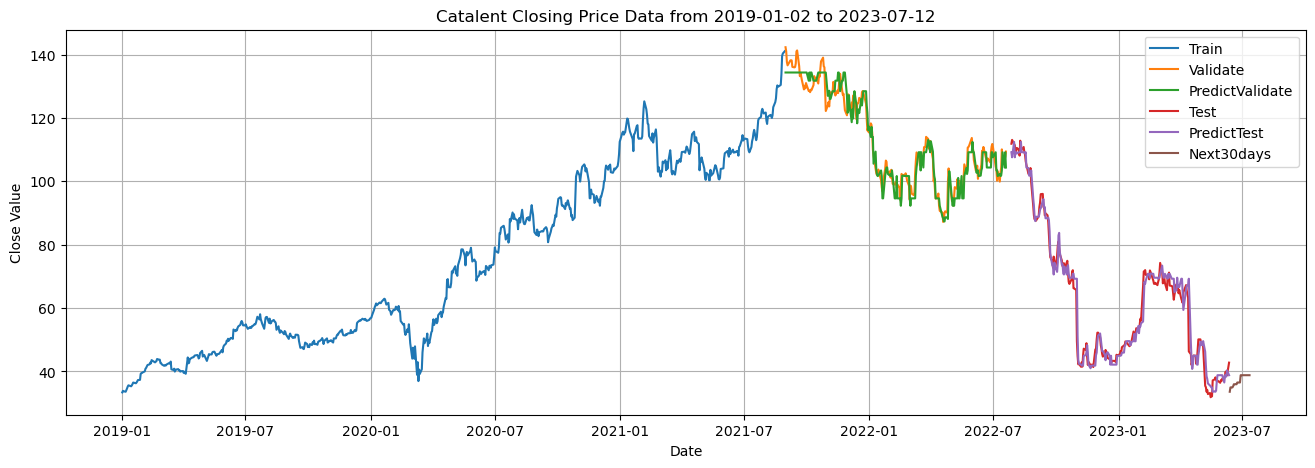

In [18]:
plt.figure(figsize=(16,5))

plt.plot(stock_ctlt.index[:train_size], y_train)

plt.plot(stock_ctlt.index[train_size: train_size + val_size], y_val)

plt.plot(stock_ctlt.index[train_size: train_size + val_size], y_pred_val)

plt.plot(stock_ctlt.index[train_size + val_size + n_in: train_size + test_size + val_size], y_test)

plt.plot(stock_ctlt.index[train_size + val_size + n_in: train_size + test_size + val_size], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Catalent Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate', 'PredictValidate', 'Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/XgBoost_622_CTLT.png')
plt.show()